# Global Sensitivity Analysis of *PFSS $\to$ WSA $\to$ HUX* for CR2053

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
from scipy import stats
from model_chain import run_chain_of_models, get_ace_date
from SA_tools.sobol import estimate_sobol
import datetime as dt
from sklearn import linear_model as lm
import chaospy
from sunpy.coordinates.sun import carrington_rotation_time
import matplotlib
import scipy
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# ACE data

In [2]:
# set up carrington rotation
CR = "2053"
start_time = carrington_rotation_time(int(CR)).to_datetime()
end_time = carrington_rotation_time(int(CR)+1).to_datetime()

# get ace data
ACE_longitude, ACE_latitude, ACE_r, ACE_vr, ACE_obstime = get_ace_date(start_time=start_time, end_time=end_time)

# Monte Carlo Simulation Results


In [3]:
N_curr = 10000
# directory with results
dir_name = os.getcwd() + "/SA_results/CR" + str(CR) + "/LHS"

In [4]:
# estimate sobol indices (MAE)
# A folder
YA_MAE = np.load(dir_name + "/simulation_MAE/YA.npy")[:N_curr]

In [5]:
# estimate sobol indices (RMSE)
YA_RMSE = np.load(dir_name + "/simulation_RMSE/YA.npy")[:N_curr]

In [6]:
# estimate sobol indices (PCC)
YA_PCC = np.load(dir_name + "/simulation_PCC/YA.npy")[:N_curr]

# Latin Hypercube Samples

In [7]:
# get samples
A = np.load("SA_results/CR" + str(CR) + "/LHS/samples/A_sample_scaled_20000.npy")[:N_curr, :]
np.shape(A)

(10000, 11)

# Construct PCE

### Define the uncertain input parameters.

In [8]:
rss = chaospy.Uniform(1.5, 4)
v0 = chaospy.Uniform(200, 400)
v1 = chaospy.Uniform(550, 950)
alpha = chaospy.Uniform(0.05, 0.5)
beta = chaospy.Uniform(1, 1.75)
w = chaospy.Uniform(0.01, 0.4)
gamma = chaospy.Uniform(0.06, 0.9)
delta = chaospy.Uniform(1, 5)
psi = chaospy.Uniform(3, 4)
alpha_acc = chaospy.Uniform(0, 0.5)
rh = chaospy.Uniform(30, 60)

joint = chaospy.J(rss, v0, v1, alpha, beta, w, gamma, delta, psi, alpha_acc, rh)

### Expansion and number of coefficients. 
The number of coefficients $b_{\beta}$ is defined by 
$$
M = \binom{p+d}{p} = \frac{(p+d)!}{p!d!}
$$

In [9]:
d=11
for p in range(1, 9):
    M = int(scipy.special.binom(d+p, p))
    print("p = " + str(p) + "=>  M = " + str(M) + " => 3M = " + str(3*M))

p = 1=>  M = 12 => 3M = 36
p = 2=>  M = 78 => 3M = 234
p = 3=>  M = 364 => 3M = 1092
p = 4=>  M = 1365 => 3M = 4095
p = 5=>  M = 4368 => 3M = 13104
p = 6=>  M = 12376 => 3M = 37128
p = 7=>  M = 31824 => 3M = 95472
p = 8=>  M = 75582 => 3M = 226746


Thus, with 10,000 samples we can compute a PCE with up to order $p=5$. 

In [11]:
expansion = chaospy.generate_expansion(order=2, dist=joint, normed=True, graded=False)
expansion.shape

(78,)

### Compute the coefficients using a non-intrusive least-squares approach

For now, lets only consider the mean absolute error between the model prediction and ACE data as the QoI. 

In [12]:
N_training = 8000

In [13]:
# type of linear solve ==> LASSO (L1 regularization)
model = lm.LassoLars(alpha=0., fit_intercept=False)
# fit the coefficients based on LASSO. 
pce, coeffs, matrix_pce = chaospy.fit_regression(polynomials=expansion, 
                                     abscissas=A[:N_training, :].T,
                                     evals=YA_MAE[:N_training], 
                                     retall=2, 
                                     model=model)

In [14]:
np.linalg.cond(matrix_pce)

1.2346345412269089

### Compute the PCE error on the testing regime

In [15]:
pce_prediction = np.zeros(N_curr - N_training)
for idx, ii in enumerate(np.arange(N_training, N_curr)):
    pce_prediction[idx] = pce(A[ii, 0], 
                              A[ii, 1], 
                              A[ii, 2], 
                              A[ii, 3], 
                              A[ii, 4], 
                              A[ii, 5], 
                              A[ii, 6], 
                              A[ii, 7], 
                              A[ii, 8], 
                              A[ii, 9], 
                              A[ii, 10])

In [16]:
np.linalg.norm(pce_prediction - YA_MAE[N_training:])

4379.474716280888

### Compute Sobol' indices analytically from constructed PCEs

In [17]:
def calc_sensitivity_sobol(d, pce, coefficients):
    # skip the first index squared. -- correct verified. 
    variance = np.sum(np.array(coefficients[1:])**2)
    # intialize main and total order indices. 
    main = np.zeros(d)
    total = np.zeros(d)
    
    # interate over polynomials and their exponents. 
    for idx, pol in enumerate(pce.exponents):
        add_total = [False,]*d
        add_main = [False,]*d

        for var in range(d):
            if pol[var] > 0:
                total[var] += coefficients[idx]**2
                
            if pol[var] > 0 and (pol[:var]== np.zeros(var)).all() and (pol[var+1:]==np.zeros(d-var-1)).all():
                 main[var] += coefficients[idx]**2

    main = main/variance
    total = total/variance
    return main, total

In [18]:
first_order_indices, total_order_indices = calc_sensitivity_sobol(d=11, pce=pce, coefficients=pce.coefficients)

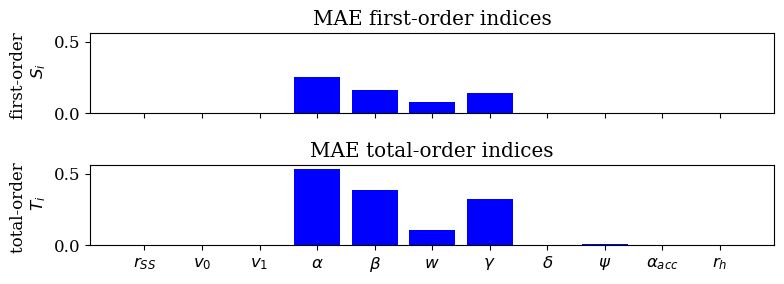

In [19]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 3))

_ = ax[0].bar(np.arange(11), first_order_indices, color="b")
_ = ax[1].bar(np.arange(11), total_order_indices, color="b")


_ = ax[0].set_title("MAE first-order indices")
_ = ax[1].set_title("MAE total-order indices")
_ = ax[0].set_xticks(np.arange(11))
_ = ax[0].set_xticklabels([r"$r_{SS}$", r"$v_{0}$", r"$v_{1}$", r"$\alpha$", r"$\beta$", r"$w$", r"$\gamma$", r"$\delta$", r"$\psi$", r"$ \alpha_{acc}$", r"$r_{h}$"])

_ = ax[0].set_ylabel("first-order \n $S_{i}$")
_ = ax[1].set_ylabel("total-order \n $T_{i}$")
plt.tight_layout()

### Find optimal regularization coefficient and polynomial degree $p$

In [ ]:
# vector of possible lambdas
lambda_vec = np.linspace(0, 1, 5)
# vector of possible p-order from 2 to 5. 
p_order_vec = np.arange(2, 6)
# save error in L2-norm for all possibilities. 
pce_prediction_vector = np.zeros((len(p_order_vec), len(lambda_vec), N_curr - N_training))

# loop over all permutations. 
for kk, lam in enumerate(lambda_vec):
    for tt, p in enumerate(p_order_vec):
        # set up Legendre expansion
        expansion = chaospy.generate_expansion(order=p, dist=joint, normed=True)
        # type of linear solve ==> LASSO (L1 regularization)
        model = lm.LassoLars(alpha=lam, fit_intercept=False)
        # fit the coefficients based on LASSO. 
        pce, coeffs, matrix_pce = chaospy.fit_regression(polynomials=expansion, 
                                             abscissas=A[:N_training, :].T,
                                             evals=YA_MAE[:N_training], 
                                             retall=2, 
                                             model=model)
        # intialize the pce prediction at testing regime. 
        pce_prediction = np.zeros(N_curr - N_training)
        for jj, ii in enumerate(np.arange(N_training, N_curr)):
            pce_prediction[jj] = pce(A[ii, 0], 
                                  A[ii, 1], 
                                  A[ii, 2], 
                                  A[ii, 3], 
                                  A[ii, 4], 
                                  A[ii, 5], 
                                  A[ii, 6], 
                                  A[ii, 7], 
                                  A[ii, 8], 
                                  A[ii, 9], 
                                  A[ii, 10])
        # compute error in testing regime in the (L2-norm).
        # i.e.  ||x||_{2} = sqrt(sum_(k=1)^n|x_k|^2)
        pce_prediction_vector[tt, kk, :] = pce_prediction 
        print(kk, tt)

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2


In [ ]:
error_l2 = np.zeros((len(p_order_vec), len(lambda_vec)))
error_inf = np.zeros((len(p_order_vec), len(lambda_vec)))

for kk, lam in enumerate(lambda_vec):
    for tt, p in enumerate(p_order_vec):
        error_l2[tt, kk] = np.linalg.norm(pce_prediction_vector[tt, kk, :] - YA_MAE[N_training:])/np.linalg.norm(YA_MAE[N_training:])
        error_inf[tt, kk] = np.linalg.norm(pce_prediction_vector[tt, kk, :] - YA_MAE[N_training:], ord=np.inf)/np.linalg.norm(YA_MAE[N_training:], ord=np.inf)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))

_ = ax[0].plot(lambda_vec, error_l2[0, :], c="b", label="$p=2$")
_ = ax[0].scatter(lambda_vec, error_l2[0, :], c="b", s=10)
_ = ax[0].plot(lambda_vec, error_l2[1, :], c="r", label="$p=3$")
_ = ax[0].scatter(lambda_vec, error_l2[1, :], c="r", s=10)
_ = ax[0].plot(lambda_vec, error_l2[2, :], c="g", label="$p=4$")
_ = ax[0].scatter(lambda_vec, error_l2[2, :], c="g", s=10)
_ = ax[0].plot(lambda_vec, error_l2[3, :], c="purple", label="$p=5$")
_ = ax[0].scatter(lambda_vec, error_l2[3, :], c="purple", s=10)
_ = ax[0].set_xlabel("regularization coefficient")
_ = ax[0].set_ylabel("$L_{2}$ relative error ")
_ = ax[0].set_title("$L_{2}$")
_ = ax[0].legend()

_ = ax[1].plot(lambda_vec, error_inf[0, :], c="b", label="$p=2$")
_ = ax[1].scatter(lambda_vec, error_inf[0, :], c="b", s=10)
_ = ax[1].plot(lambda_vec, error_inf[1, :], c="r", label="$p=3$")
_ = ax[1].scatter(lambda_vec, error_inf[1, :], c="r", s=10)
_ = ax[1].plot(lambda_vec, error_inf[2, :], c="g", label="$p=4$")
_ = ax[1].scatter(lambda_vec, error_inf[2, :], c="g", s=10)
_ = ax[1].plot(lambda_vec, error_inf[3, :], c="purple", label="$p=5$")
_ = ax[1].scatter(lambda_vec, error_inf[3, :], c="purple", s=10)

_ = ax[1].set_xlabel("regularization coefficient")
_ = ax[1].set_ylabel("$L_{\infty}$ relative error ")
_ = ax[1].set_title("$L_{\infty}$")
_ = ax[1].legend()
plt.tight_layout()

In [ ]:
index = np.unravel_index(error_l2.argmin(), error_l2.shape)
print("optimal L-2 lambda = ", lambda_vec[index[1]])
print("optimal L-2 p = ", p_order_vec[index[0]])

In [ ]:
index = np.unravel_index(error_inf.argmin(), error_inf.shape)
print("optimal L-inf lambda = ", lambda_vec[index[1]])
print("optimal L-inf p = ", p_order_vec[index[0]])